# Imports

In [1]:
from paddleocr import PaddleOCR

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [60]:
def show_img(img, cmap=None):
    fig, ax  = plt.subplots(figsize=(16, 9))

    ax.imshow(img, cmap=cmap)
    ax.axis("off")

    plt.show()

# Image

In [2]:
IMG = "../data/photo_2024-05-23_15-18-57.jpg"

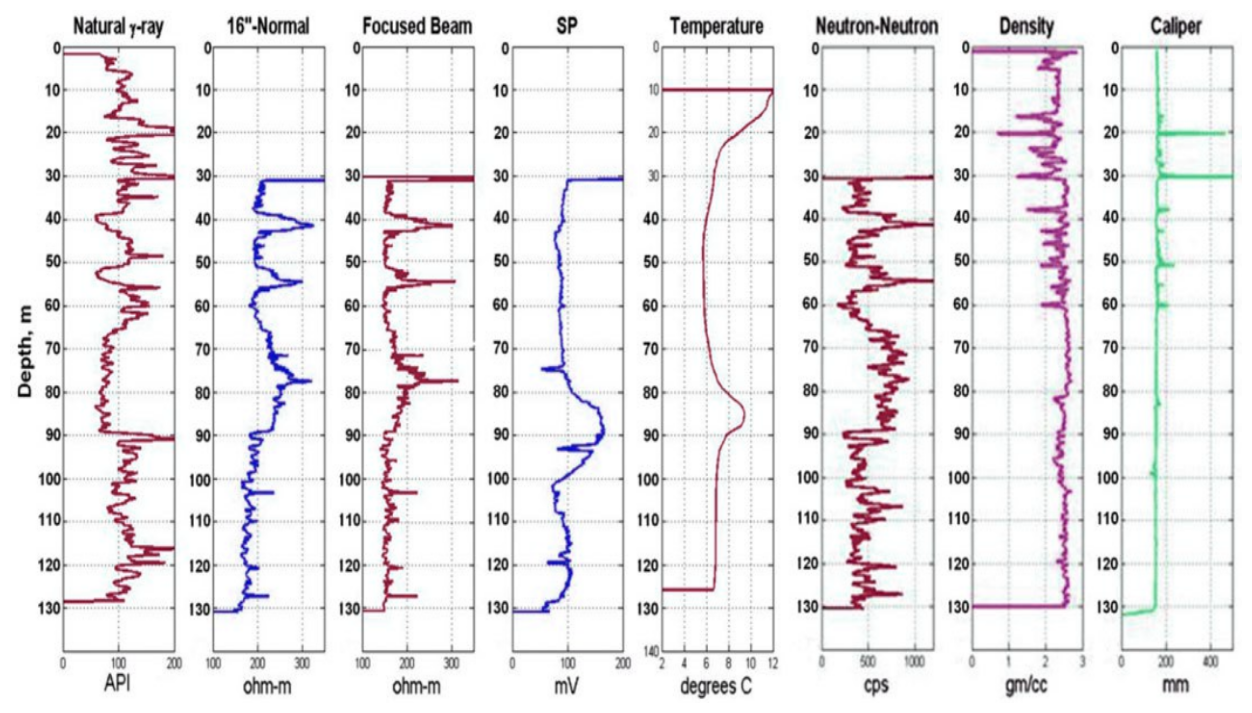

In [43]:
img = cv2.imread(IMG)
img = cv2.resize(img, (1280, 720))

show_img(img)

# Paddle

In [44]:
ocr = PaddleOCR(
    ocr_version="PP-OCRv4",
    use_angle_cls=True,
    lang="en",
    use_gpu=False,
    show_log=False,
)

In [45]:
pred = ocr.ocr(img)

In [46]:
boxes = [p[0] for p in pred[0]]
texts = [p[1][0] for p in pred[0]]
scores = [p[1][1] for p in pred[0]]

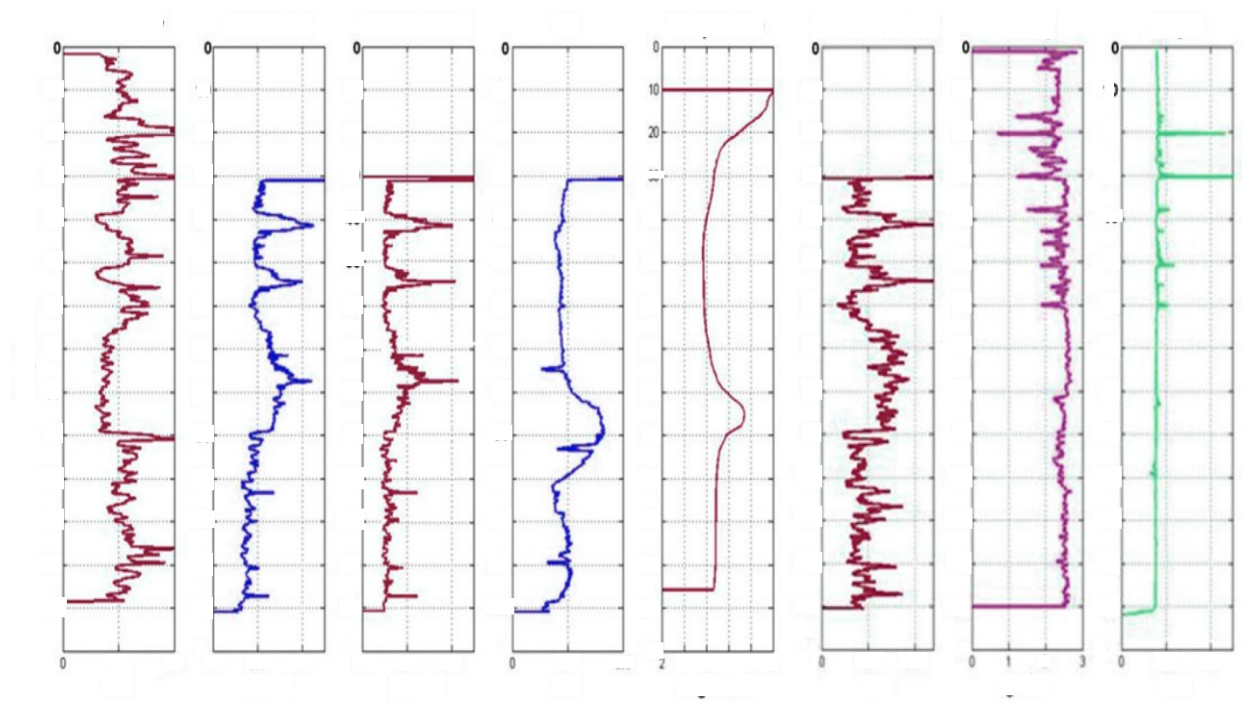

In [47]:
img_copy = img.copy()
NARROW = 1
THRESHOLD = 0.85

for box, score in zip(boxes, scores):
    x1, y1 = box[0]
    x2, y2 = box[2]
    x1, y1 = int(x1 - NARROW), int(y1 - NARROW) 
    x2, y2 = int(x2 - NARROW), int(y2 - NARROW)

    if score > THRESHOLD:
        cv2.rectangle(
            img_copy,
            (x1, y1),
            (x2, y2),
            (255, 255, 255),
            -1,
        ) 

show_img(img_copy)

# Boundaries

In [120]:
def filter(src, win_size=5):
    dst = src.copy()

    for i in range(win_size, len(src) -  win_size):
        win = src[i - win_size : i + win_size]
        vals, counts = np.unique(win, return_counts=True)
        most = vals[np.argmax(counts)]
        dst[i] = most

    return dst

def find_boundaries(src):
    # print(src.tolist())
    boundaries = np.zeros_like(src)

    for i in range(len(src) - 1):
        # curr = src[i]
        # prev = src[i - 1]
        # a = abs(curr - prev)
        if abs(src[i] - src[i + 1]) > 250:
            boundaries[i] = 1

    boundaries = np.where(boundaries == 1)[0]

    return boundaries

In [132]:
ocr_img = cv2.cvtColor(img_copy.copy(), cv2.COLOR_BGR2GRAY)

THRESHOLD = 253

col_mean = ocr_img.mean(axis=0).astype(int)
col_mean[col_mean < THRESHOLD] = 0
col_mean[col_mean >= THRESHOLD] = 255

col_mean = filter(col_mean)
boundaries_v = find_boundaries(col_mean)

In [133]:
ocr_img = cv2.cvtColor(img_copy.copy(), cv2.COLOR_BGR2GRAY)

THRESHOLD = 253

row_mean = ocr_img.mean(axis=1).astype(int)

row_mean[row_mean < THRESHOLD] = 0
row_mean[row_mean >= THRESHOLD] = 255

row_mean = filter(row_mean)
boundaries_h = find_boundaries(row_mean)

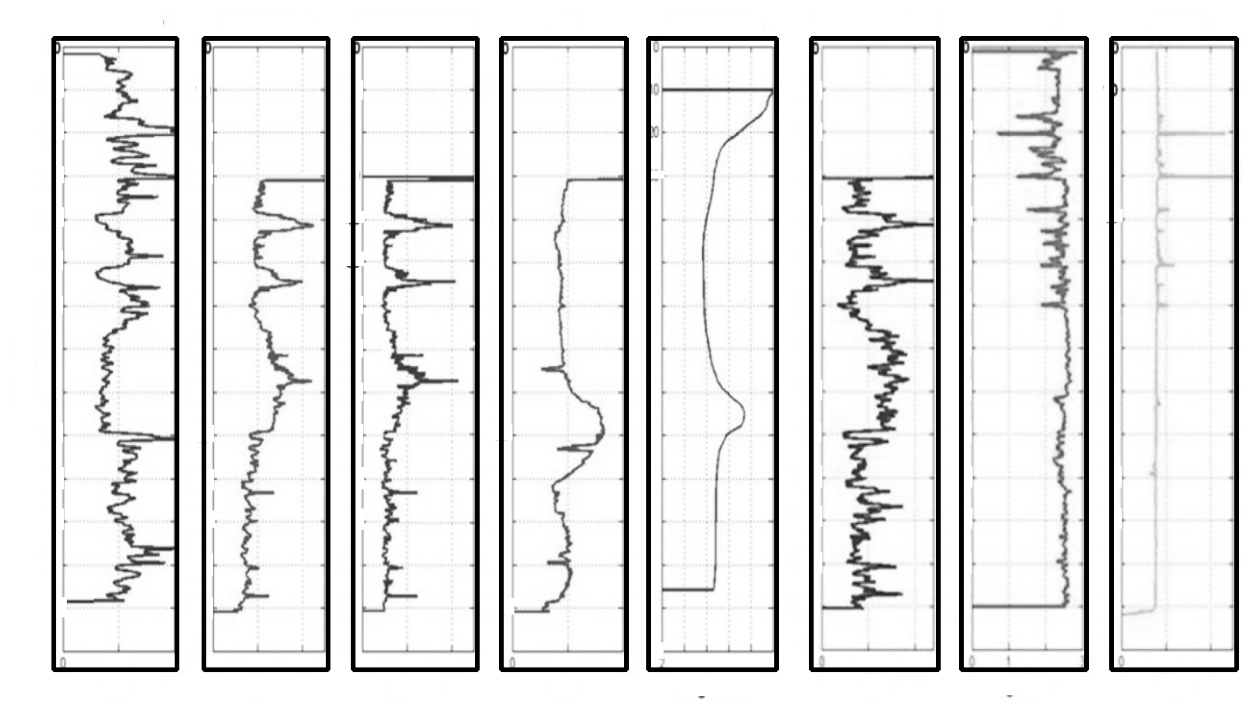

In [134]:
fig, ax = plt.subplots(figsize=(16, 9))

high, low = boundaries_h

for left, right in zip(boundaries_v[::2], boundaries_v[1::2]):
    x1, y1 = left, high
    x2, y2 = right, low

    cv2.rectangle(
        ocr_img,
        (x1, y1),
        (x2, y2),
        (0, 0, 255),
        3,
    )

ax.imshow(ocr_img, cmap="Greys_r")
ax.axis("off")

# for boundary in boundaries_v:
#     ax.vlines(boundary, 0, ocr_img.shape[0], linestyles="--", colors="black")

# for boundary in boundaries_h:
#     ax.hlines(boundary, 0, ocr_img.shape[1], linestyles="--", colors="black")



plt.show()